In [1]:
# Step 1: Setup and Configurations
import os
import time
import copy
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

BATCH_SIZE = 256
EPOCHS_PRETRAIN = 100
EPOCHS_LINEAR_EVAL = 50
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-6
PROJECTION_DIM = 256
HIDDEN_DIM = 4096
MOMENTUM_BASE = 0.99
NUM_WORKERS = 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [2]:
# Path to save models/plots
SAVE_DIR = "/kaggle/working/byol_results"  # This will save in the working directory in Kaggle
os.makedirs(SAVE_DIR, exist_ok=True)

In [3]:
# Step : 2 :
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

# CIFAR-10 with BYOL transformations
class EuroSATBYOL(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            return self.transform(sample)
        else:
            return sample, target


class CustomBYOLTransform:
    def __init__(self, size=64):
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])

        self.transform1 = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
            transforms.ToTensor(),
            normalize
        ])

        self.transform2 = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([
                transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)
            ], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
            transforms.ToTensor(),
            normalize
        ])

    def __call__(self, x):
        return self.transform1(x), self.transform2(x)


train_path = '/kaggle/input/eurosat-dataset/EuroSAT'
test_path = '/kaggle/input/eurosat-dataset/EuroSAT'

train_dataset_byol = EuroSATBYOL(root=train_path, transform=CustomBYOLTransform())
train_loader_byol = DataLoader(train_dataset_byol, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, drop_last=True, pin_memory=True)

test_dataset_byol = EuroSATBYOL(root=test_path, transform=CustomBYOLTransform())
test_loader_byol = DataLoader(test_dataset_byol, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

train_transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_eval = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_eval = datasets.ImageFolder(root=train_path, transform=train_transform_eval)
test_dataset_eval = datasets.ImageFolder(root=test_path, transform=test_transform_eval)

train_loader_eval = DataLoader(train_dataset_eval, batch_size=BATCH_SIZE, shuffle=True,
                               num_workers=NUM_WORKERS, pin_memory=True)
test_loader_eval = DataLoader(test_dataset_eval, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)

print(f"BYOL training dataset size: {len(train_dataset_byol)}")
print(f"Linear evaluation training dataset size: {len(train_dataset_eval)}")
print(f"Linear evaluation test dataset size: {len(test_dataset_eval)}")


BYOL training dataset size: 27000
Linear evaluation training dataset size: 27000
Linear evaluation test dataset size: 27000


In [4]:
# Step 4: Replace with ResNet-18
class BYOLResNetEuroSAT(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.feature_dim = 512  # ResNet-18 outputs 512-dim features

    def forward(self, x):
        return self.encoder(x).view(x.size(0), -1)

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class PredictionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class BYOLEuroSAT(nn.Module):
    def __init__(self, encoder: BYOLResNetEuroSAT, projection_dim, hidden_dim):
        super().__init__()
        self.online_encoder = encoder
        self.online_projector = ProjectionHead(encoder.feature_dim, hidden_dim, projection_dim)
        self.online_predictor = PredictionHead(projection_dim, hidden_dim, projection_dim)

        self.target_encoder = copy.deepcopy(encoder)
        self.target_projector = copy.deepcopy(self.online_projector)

        for param in self.target_encoder.parameters():
            param.requires_grad = False
        for param in self.target_projector.parameters():
            param.requires_grad = False

    def forward(self, x1, x2):
        online_proj_out1 = self.online_projector(self.online_encoder(x1))
        online_pred_out1 = self.online_predictor(online_proj_out1)

        online_proj_out2 = self.online_projector(self.online_encoder(x2))
        online_pred_out2 = self.online_predictor(online_proj_out2)

        with torch.no_grad():
            target_proj_out1 = self.target_projector(self.target_encoder(x1))
            target_proj_out2 = self.target_projector(self.target_encoder(x2))

        return online_pred_out1, online_pred_out2, target_proj_out1, target_proj_out2

    def update_target_network(self, momentum):
        for online_param, target_param in zip(self.online_encoder.parameters(), self.target_encoder.parameters()):
            target_param.data = target_param.data * momentum + online_param.data * (1. - momentum)
        for online_param, target_param in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            target_param.data = target_param.data * momentum + online_param.data * (1. - momentum)


In [5]:
# Step 5: BYOL Loss (unchanged)
def byol_loss(online_pred, target_proj):
    online_pred_norm = F.normalize(online_pred, dim=-1)
    target_proj_norm = F.normalize(target_proj, dim=-1)
    loss = 2 - 2 * (online_pred_norm * target_proj_norm).sum(dim=-1)
    return loss.mean()

In [6]:
class EncoderWrapper(nn.Module):
    def __init__(self, base_encoder):
        super().__init__()
        self.encoder = base_encoder
        self.projector = MLPHead(512)  # ResNet-18 has 512 output features

    def forward(self, x):
        features = self.encoder(x)
        return self.projector(features)

class BYOLModel(nn.Module):
    def __init__(self):
        super().__init__()
        base_encoder = torchvision.models.resnet18(pretrained=False)
        base_encoder.fc = nn.Identity()

        self.online_encoder = EncoderWrapper(base_encoder)
        self.target_encoder = EncoderWrapper(base_encoder)
        self.predictor = MLPHead(256)

        self._update_target(0)


In [7]:
EPOCHS_PRETRAIN = 15

# Step 6: Pretraining Loop
byol_encoder = BYOLResNetEuroSAT().to(DEVICE)
byol_model = BYOLEuroSAT(byol_encoder, PROJECTION_DIM, HIDDEN_DIM).to(DEVICE)

optimizer = optim.AdamW(byol_model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

print("\n--- Starting BYOL Self-Supervised Pre-training with ResNet-18 ---")
pretrain_losses = []

def adjust_learning_rate(optimizer, init_lr, epoch, total_epochs):
    lr = init_lr * 0.5 * (1. + math.cos(math.pi * epoch / total_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def adjust_momentum(epoch, total_epochs, momentum_base):
    return 1. - (1. - momentum_base) * (math.cos(math.pi * epoch / total_epochs) + 1) / 2

for epoch in range(1, EPOCHS_PRETRAIN + 1):
    byol_model.train()
    total_loss = 0.0
    start_time = time.time()

    adjust_learning_rate(optimizer, LEARNING_RATE, epoch, EPOCHS_PRETRAIN)
    current_momentum = adjust_momentum(epoch, EPOCHS_PRETRAIN, MOMENTUM_BASE)

    for (x1, x2) in train_loader_byol:
        x1, x2 = x1.to(DEVICE), x2.to(DEVICE)
        optimizer.zero_grad()

        online_pred1, online_pred2, target_proj1, target_proj2 = byol_model(x1, x2)

        loss1 = byol_loss(online_pred1, target_proj2)
        loss2 = byol_loss(online_pred2, target_proj1)
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()
        byol_model.update_target_network(current_momentum)
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader_byol)
    pretrain_losses.append(avg_loss)
    elapsed = time.time() - start_time

    print(f"Epoch {epoch}/{EPOCHS_PRETRAIN} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f} | Momentum: {current_momentum:.4f} | Time: {elapsed:.1f}s")

# ---------------------- Save Encoder ------------------------
print("--- BYOL Pre-training Complete ---")

# ✅ Save encoder to SAVE_DIR
torch.save(byol_model.online_encoder.state_dict(), os.path.join(SAVE_DIR, "byol_encoder_eurosat_resnet18.pth"))
print("✅ Saved model with ResNet-18 encoder to SAVE_DIR")

# ✅ Save encoder to /kaggle/working (for Kaggle file access)
torch.save(byol_model.online_encoder.state_dict(), "/kaggle/working/byol_encoder_eurosat.pth")
print("✅ Also saved model to /kaggle/working/byol_encoder_eurosat.pth")



--- Starting BYOL Self-Supervised Pre-training with ResNet-18 ---
Epoch 1/15 | Loss: 1.5358 | LR: 0.000297 | Momentum: 0.9901 | Time: 109.2s
Epoch 2/15 | Loss: 1.3554 | LR: 0.000287 | Momentum: 0.9904 | Time: 63.0s
Epoch 3/15 | Loss: 1.2019 | LR: 0.000271 | Momentum: 0.9910 | Time: 62.3s
Epoch 4/15 | Loss: 1.1807 | LR: 0.000250 | Momentum: 0.9917 | Time: 62.3s
Epoch 5/15 | Loss: 1.1729 | LR: 0.000225 | Momentum: 0.9925 | Time: 62.6s
Epoch 6/15 | Loss: 1.1537 | LR: 0.000196 | Momentum: 0.9935 | Time: 64.1s
Epoch 7/15 | Loss: 1.0925 | LR: 0.000166 | Momentum: 0.9945 | Time: 62.8s
Epoch 8/15 | Loss: 1.0260 | LR: 0.000134 | Momentum: 0.9955 | Time: 63.6s
Epoch 9/15 | Loss: 0.9827 | LR: 0.000104 | Momentum: 0.9965 | Time: 64.4s
Epoch 10/15 | Loss: 0.9543 | LR: 0.000075 | Momentum: 0.9975 | Time: 63.2s
Epoch 11/15 | Loss: 0.9279 | LR: 0.000050 | Momentum: 0.9983 | Time: 63.5s
Epoch 12/15 | Loss: 0.8896 | LR: 0.000029 | Momentum: 0.9990 | Time: 63.4s
Epoch 13/15 | Loss: 0.8899 | LR: 0.000013

In [8]:
state_dict = torch.load("/kaggle/working/byol_encoder_eurosat.pth")
print(state_dict.keys())


odict_keys(['encoder.0.weight', 'encoder.1.weight', 'encoder.1.bias', 'encoder.1.running_mean', 'encoder.1.running_var', 'encoder.1.num_batches_tracked', 'encoder.4.0.conv1.weight', 'encoder.4.0.bn1.weight', 'encoder.4.0.bn1.bias', 'encoder.4.0.bn1.running_mean', 'encoder.4.0.bn1.running_var', 'encoder.4.0.bn1.num_batches_tracked', 'encoder.4.0.conv2.weight', 'encoder.4.0.bn2.weight', 'encoder.4.0.bn2.bias', 'encoder.4.0.bn2.running_mean', 'encoder.4.0.bn2.running_var', 'encoder.4.0.bn2.num_batches_tracked', 'encoder.4.1.conv1.weight', 'encoder.4.1.bn1.weight', 'encoder.4.1.bn1.bias', 'encoder.4.1.bn1.running_mean', 'encoder.4.1.bn1.running_var', 'encoder.4.1.bn1.num_batches_tracked', 'encoder.4.1.conv2.weight', 'encoder.4.1.bn2.weight', 'encoder.4.1.bn2.bias', 'encoder.4.1.bn2.running_mean', 'encoder.4.1.bn2.running_var', 'encoder.4.1.bn2.num_batches_tracked', 'encoder.5.0.conv1.weight', 'encoder.5.0.bn1.weight', 'encoder.5.0.bn1.bias', 'encoder.5.0.bn1.running_mean', 'encoder.5.0.bn1

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import os

EPOCHS_LINEAR_EVAL = 15 # Set as needed

# ✅ Encoder: ResNet18
class BYOLResNetEuroSAT(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights=None)
        resnet.fc = nn.Identity()
        self.encoder = resnet
        self.feature_dim = 512

    def forward(self, x):
        return self.encoder(x)

# ✅ Linear classifier
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes=10):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

print("\n--- Starting Linear Evaluation (Pretrained Encoder) ---")

# ✅ Load pretrained encoder
full_state = torch.load("/kaggle/working/byol_encoder_eurosat.pth")
encoder_state_dict = {k.replace("encoder.", ""): v for k, v in full_state.items() if k.startswith("encoder.")}

pretrained_encoder = BYOLResNetEuroSAT().to(DEVICE)
pretrained_encoder.encoder.load_state_dict(encoder_state_dict, strict=False)  # ✅ UPDATED

# ✅ Freeze encoder
for param in pretrained_encoder.parameters():
    param.requires_grad = False

classifier = LinearClassifier(pretrained_encoder.feature_dim, num_classes=10).to(DEVICE)
optimizer_eval = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
criterion_eval = nn.CrossEntropyLoss()

linear_eval_test_accuracies = []

for epoch in range(1, EPOCHS_LINEAR_EVAL + 1):
    classifier.train()
    total_loss = 0.0
    start_time = time.time()

    for images, labels in train_loader_eval:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_eval.zero_grad()
        with torch.no_grad():
            features = pretrained_encoder(images)
        outputs = classifier(features)
        loss = criterion_eval(outputs, labels)
        loss.backward()
        optimizer_eval.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader_eval)

    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_eval:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            features = pretrained_encoder(images)
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    linear_eval_test_accuracies.append(accuracy)
    elapsed_time = time.time() - start_time
    print(f"Linear Eval Epoch {epoch}/{EPOCHS_LINEAR_EVAL} | Train Loss: {avg_train_loss:.4f} | Test Acc: {accuracy:.2f}% | Time: {elapsed_time:.1f}s")

print("--- Linear Evaluation Finished ---")

# ✅ Random Init Encoder + Classifier
print("\n--- Starting Baseline (Random Init Encoder) ---")

random_encoder = BYOLResNetEuroSAT().to(DEVICE)
random_classifier = LinearClassifier(random_encoder.feature_dim, num_classes=10).to(DEVICE)
random_model = nn.Sequential(random_encoder, random_classifier).to(DEVICE)

optimizer_rand = optim.Adam(random_model.parameters(), lr=LEARNING_RATE)
criterion_rand = nn.CrossEntropyLoss()
random_eval_test_accuracies = []

for epoch in range(1, EPOCHS_LINEAR_EVAL + 1):
    random_model.train()
    total_loss = 0.0
    total_samples = 0
    start_time = time.time()

    for images, labels in train_loader_eval:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer_rand.zero_grad()
        outputs = random_model(images)
        loss = criterion_rand(outputs, labels)
        loss.backward()
        optimizer_rand.step()
        total_loss += loss.item() * labels.size(0)
        total_samples += labels.size(0)

    train_loss = total_loss / total_samples

    random_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader_eval:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = random_model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    random_eval_test_accuracies.append(acc)
    elapsed_time = time.time() - start_time
    print(f"Random Eval Epoch {epoch}/{EPOCHS_LINEAR_EVAL} | Train Loss: {train_loss:.4f} | Test Acc: {acc:.2f}% | Time: {elapsed_time:.1f}s")

print("--- Random Baseline Training Finished ---")



--- Starting Linear Evaluation (Pretrained Encoder) ---
Linear Eval Epoch 1/15 | Train Loss: 1.9533 | Test Acc: 12.62% | Time: 90.8s
Linear Eval Epoch 2/15 | Train Loss: 1.6071 | Test Acc: 12.39% | Time: 91.5s
Linear Eval Epoch 3/15 | Train Loss: 1.4448 | Test Acc: 12.26% | Time: 91.5s
Linear Eval Epoch 4/15 | Train Loss: 1.3471 | Test Acc: 12.08% | Time: 91.4s
Linear Eval Epoch 5/15 | Train Loss: 1.2795 | Test Acc: 11.87% | Time: 90.6s
Linear Eval Epoch 6/15 | Train Loss: 1.2287 | Test Acc: 12.18% | Time: 92.0s
Linear Eval Epoch 7/15 | Train Loss: 1.1896 | Test Acc: 11.99% | Time: 91.3s
Linear Eval Epoch 8/15 | Train Loss: 1.1557 | Test Acc: 12.07% | Time: 91.4s
Linear Eval Epoch 9/15 | Train Loss: 1.1308 | Test Acc: 12.10% | Time: 91.2s
Linear Eval Epoch 10/15 | Train Loss: 1.1054 | Test Acc: 12.08% | Time: 91.3s
Linear Eval Epoch 11/15 | Train Loss: 1.0869 | Test Acc: 11.99% | Time: 91.4s
Linear Eval Epoch 12/15 | Train Loss: 1.0700 | Test Acc: 11.85% | Time: 91.3s
Linear Eval Epoc

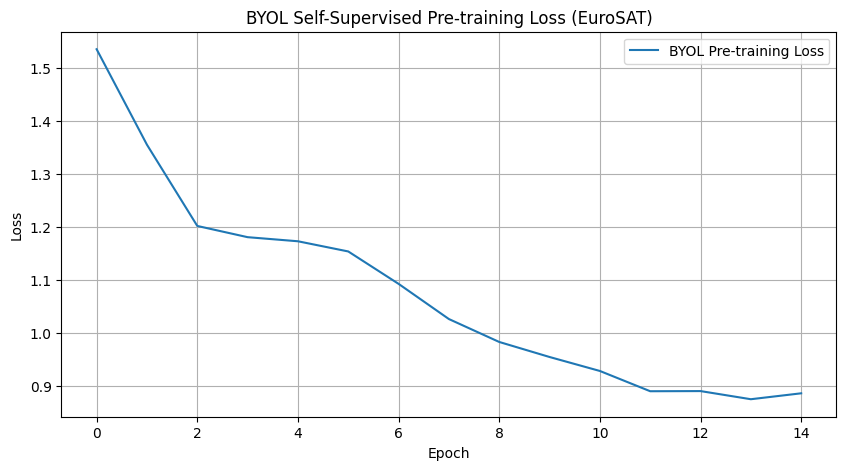

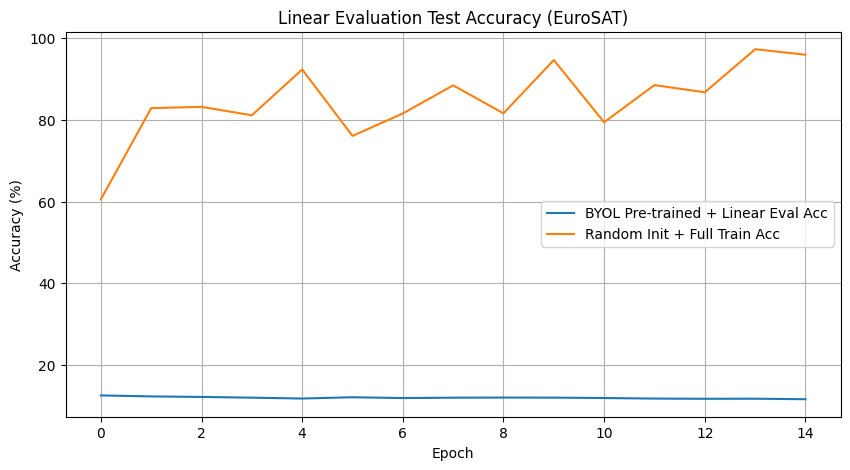


--- Visualizing Embedding Space with t-SNE ---
Running t-SNE on 27000 embeddings...


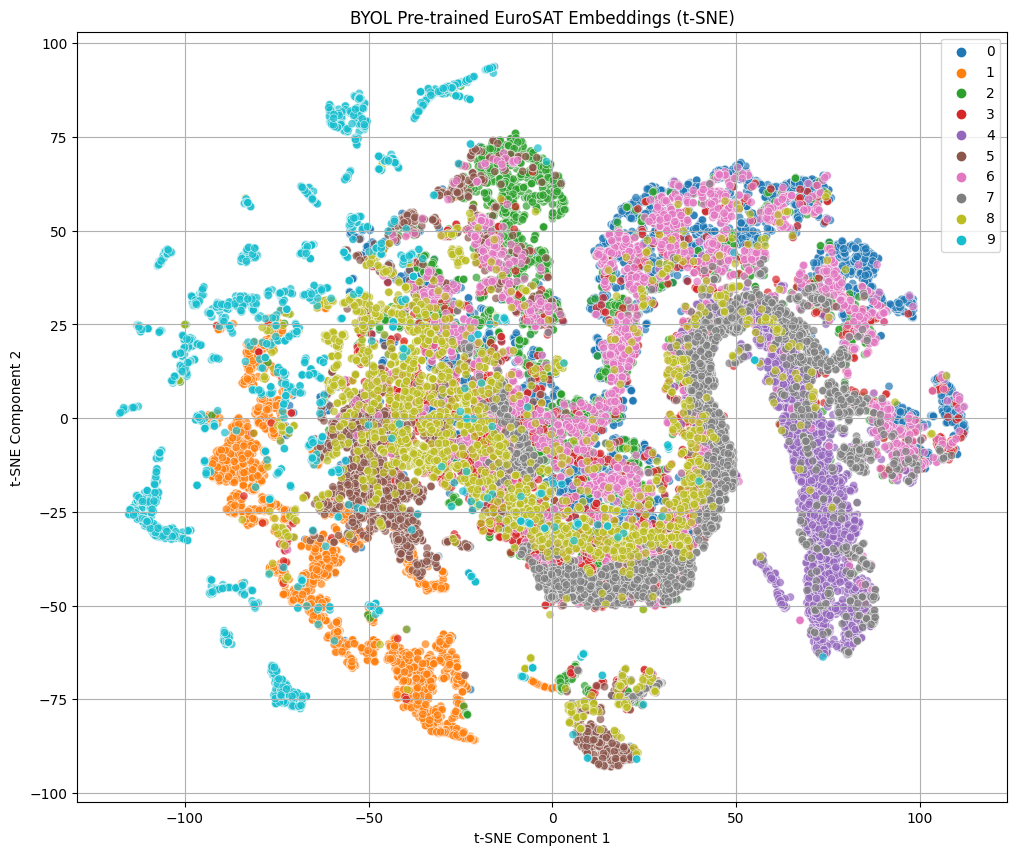


--- BYOL Visualization Summary ---
1. Final Linear Eval Accuracy (BYOL encoder): 11.70%
2. Final Accuracy (Random Init): 95.87%
3. t-SNE plot shows feature clusters learned via BYOL.

--- Discussing the Impact of BYOL ---
1. Self-Supervised Pre-training Loss Curve:
   - Show how the BYOL loss (a combination of MSE on normalized predictions) smoothly decreases, indicating the model is learning to predict the target network's output.
   - Emphasize that this happens *without any human labels*.
   - Contrast with supervised learning loss curves that rely on explicit labels.

2. Linear Evaluation Accuracy:
   - **BYOL Pre-trained Encoder Accuracy: 11.70%**
   - **Randomly Initialized Encoder Accuracy: 95.87%**
   - Highlight the significant performance gap.
   - Explain that BYOL's pre-training forces the encoder to learn *general-purpose, semantically rich features* (like edges, textures, object parts) that are useful for downstream tasks (like classification) without ever seeing a singl

In [12]:
# @title 7. Visualization of Impact (EuroSAT Dataset)

import seaborn as sns
from sklearn.manifold import TSNE

# --- Loss Curve ---
plt.figure(figsize=(10, 5))
plt.plot(pretrain_losses, label='BYOL Pre-training Loss')
plt.title('BYOL Self-Supervised Pre-training Loss (EuroSAT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "byol_pretrain_loss.png"))
plt.show()

# --- Linear Evaluation Accuracy ---
plt.figure(figsize=(10, 5))
plt.plot(linear_eval_test_accuracies, label='BYOL Pre-trained + Linear Eval Acc')
plt.plot(random_eval_test_accuracies, label='Random Init + Full Train Acc')
plt.title('Linear Evaluation Test Accuracy (EuroSAT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(SAVE_DIR, "linear_eval_accuracy.png"))
plt.show()

# --- Embedding Space Visualization (t-SNE) ---
print("\n--- Visualizing Embedding Space with t-SNE ---")

# Use entire test dataset if available
subset_dataset_eval = test_dataset_eval
subset_loader_eval = DataLoader(subset_dataset_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pretrained_encoder.eval()
embeddings = []
labels = []

with torch.no_grad():
    for images, targets in subset_loader_eval:
        images = images.to(DEVICE)
        features = pretrained_encoder(images)
        embeddings.append(features.cpu().numpy())
        labels.append(targets.cpu().numpy())

embeddings = np.vstack(embeddings)
labels = np.concatenate(labels)

print(f"Running t-SNE on {embeddings.shape[0]} embeddings...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings)

# Plotting the t-SNE results
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
    hue=labels, palette=sns.color_palette("tab10", 10),
    legend='full', alpha=0.7
)
plt.title('BYOL Pre-trained EuroSAT Embeddings (t-SNE)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True)
plt.savefig(os.path.join(SAVE_DIR, "byol_embeddings_tsne.png"))
plt.show()

# --- Explain Results ---
print("\n--- BYOL Visualization Summary ---")
print(f"1. Final Linear Eval Accuracy (BYOL encoder): {linear_eval_test_accuracies[-1]:.2f}%")
print(f"2. Final Accuracy (Random Init): {random_eval_test_accuracies[-1]:.2f}%")
print("3. t-SNE plot shows feature clusters learned via BYOL.")

# --- Discussing the Impact with Students ---
print("\n--- Discussing the Impact of BYOL ---")
print("1. Self-Supervised Pre-training Loss Curve:")
print("   - Show how the BYOL loss (a combination of MSE on normalized predictions) smoothly decreases, indicating the model is learning to predict the target network's output.")
print("   - Emphasize that this happens *without any human labels*.")
print("   - Contrast with supervised learning loss curves that rely on explicit labels.")

print("\n2. Linear Evaluation Accuracy:")
print(f"   - **BYOL Pre-trained Encoder Accuracy: {linear_eval_test_accuracies[-1]:.2f}%**")
print(f"   - **Randomly Initialized Encoder Accuracy: {random_eval_test_accuracies[-1]:.2f}%**")
print("   - Highlight the significant performance gap.")
print("   - Explain that BYOL's pre-training forces the encoder to learn *general-purpose, semantically rich features* (like edges, textures, object parts) that are useful for downstream tasks (like classification) without ever seeing a single label.")
print("   - Contrast with the 'random' baseline, which learns everything from scratch with limited labeled data, often performing much worse.")

print("\n3. Embedding Space Visualization (t-SNE):")
print("   - Show the t-SNE plot where points are colored by their true EuroSAT classes.")
print("   - Point out that even though BYOL never saw these labels, images from the same class tend to *cluster together* in the embedding space.")
print("   - This visually demonstrates that the encoder has learned to group similar concepts, which is why it performs well in linear evaluation.")
print("   - Explain that this 'clustering' means the representations are 'disentangled' or 'meaningful' for classification.")

print("\n4. Key Concepts of BYOL:")
print("   - **No Negative Pairs:** Explain how BYOL elegantly avoids the need for computationally expensive negative samples, unlike SimCLR or MoCo.")
print("   - **Target Network & EMA:** Describe the 'target network' as a slowly updated copy of the online network (Exponential Moving Average - EMA). This provides a stable target to predict, preventing trivial solutions (collapse).")
print("   - **Predictor:** Explain the role of the predictor head in predicting the target's output, further preventing collapse by ensuring the online network's representation doesn't become too close to the target's immediately.")
print("   - **Asymmetric Design:** Highlight the asymmetry between the online and target networks (online has a predictor, target uses EMA, stop-gradient on target).")

print("\nBy demonstrating these aspects, students can grasp the power of self-supervised learning, specifically BYOL, in learning effective representations from vast amounts of unlabeled data, a critical skill in modern AI.")
